In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import truncnorm, gamma, norm, cosine, invgamma, gennorm
import scipy.special as sc
from tqdm import tqdm
import math
import torch
import pickle

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
#read in the raw data from just 2023 so there are no shifts
from google.colab import drive
drive.mount('/drive')

raw23= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw23.csv')
raw23 = raw23.loc[raw23['type'] == 'X']

Mounted at /drive


In [ ]:
#we only want balls in play with non-null measurements
all_data = raw23.loc[raw23['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

### Physics

In [ ]:
#load the ml models
model_t = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/hangtime_model.pkl', 'rb'))
model_d = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/landing_dist_model.pkl', 'rb'))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:12:12] WARNING: /workspace/src/gbm/gbtree.cc:360: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:12:12] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:12:12] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [ ]:
#make predictions
all_data['hangtime'] = model_t.predict(all_data[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
all_data['distance'] = model_d.predict(all_data[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)

#calculate landing x and y
all_data['landing_x'] = all_data.distance.values * np.sin(np.pi * all_data.hit_direction.values / 180)
all_data['landing_y'] = all_data.distance.values * np.cos(np.pi * all_data.hit_direction.values / 180)

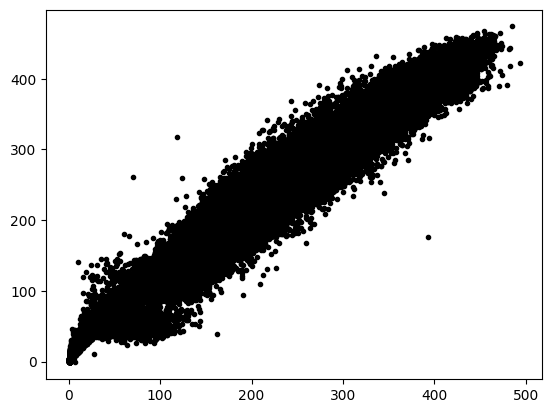

In [ ]:
plt.plot(all_data.hit_distance_sc.values, all_data.distance.values, 'k.')
plt.show()

In [ ]:
t = all_data.loc[np.isnan(all_data.hit_distance_sc)==False]
np.corrcoef(t.hit_distance_sc.values, t.distance.values)

array([[1.        , 0.99119813],
       [0.99119813, 1.        ]])

In [ ]:
np.sqrt(np.mean((t.hit_distance_sc.values - t.distance.values)**2))

21.757688091706314

### Flyball Out model

In [ ]:
#launch angle type
all_data['la_type'] = 0 #gb
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <= 25), 'la_type'] = 1 #ld
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <= 50), 'la_type'] = 2 #fb
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3 #pu
all_data['is_gb'] = 0
all_data['is_ld'] = 0
all_data['is_fb'] = 0
all_data['is_pu'] = 0
all_data.loc[all_data.la_type == 0, 'is_gb'] = 1
all_data.loc[all_data.la_type == 1, 'is_ld'] = 1
all_data.loc[all_data.la_type == 2, 'is_fb'] = 1
all_data.loc[all_data.la_type == 3, 'is_pu'] = 1

all_data['outcome'] = -1
all_data.loc[all_data.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice',
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 'sac_bunt',
                                               'sac_fly_double_play']), 'outcome'] = 0 # in play out
all_data.loc[all_data.events == 'single', 'outcome'] = 1 #single
all_data.loc[all_data.events == 'double', 'outcome'] = 2 # double
all_data.loc[all_data.events == 'triple', 'outcome'] = 3 #triple
all_data.loc[all_data.events == 'home_run', 'outcome'] = 4 #hr

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'launch_speed', 'launch_angle', 'on_3b', 'on_2b', 'on_1b', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR', 'x', 'y', 'hit_direction', 'la_type', 'is_gb','is_ld', 'is_fb', 'is_pu', 'landing_x', 'landing_y', 'distance', 'hangtime', 'outcome', 'events']]

#we only need non groundballs
df = all_data.loc[all_data.is_gb == 0]

In [ ]:
#remove non standard outfield plays
df = df.loc[df.of_fielding_alignment == 'Standard']

#define infield and outfield positions the same way we did in the groundball notebook
#initialize infielder depths and angles
df[['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']]= np.array([34, 12, -32,-13,111,148,119,147, -27, 0, 27, 297, 322, 294])

#I literally eyeballed these and guessed :( I used the situation where there were no baserunners, so remove plays with baserunners
df = df.loc[(np.isnan(df.on_3b)) & (np.isnan(df.on_2b)) & (np.isnan(df.on_1b))]
df.loc[(df.bat_handR == 0) & (df.if_fielding_alignment == 'Infield shade'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']] = np.array([42, 20, -22.5, -5, 126, 147, 132, 152, -27,-1,27,297,323,294])
df.loc[(df.bat_handR == 0) & (df.if_fielding_alignment == 'Standard'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']] = np.array([42, 20, -27, -7.5, 124, 148, 117, 152, -30, -5, 26, 293, 329, 302])

df.loc[(df.bat_handR == 1) & (df.if_fielding_alignment == 'Infield shade'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']] = np.array([28, 5, -42.5, -20, 116, 154, 125, 145, -27, 1, 27, 303,323,291])
df.loc[(df.bat_handR == 1) & (df.if_fielding_alignment == 'Standard'), ['a3', 'a4','a5','a6', 'd3','d4','d5','d6', 'a7', 'a8', 'a9', 'd7', 'd8', 'd9']] = np.array([30, 7.5, -42.5, -20, 116, 153, 118, 148, -25,5,29,300,321,293])

#use angle and depth to calculate coordinates
df['x3'] = df.d3.values * np.sin(np.pi * df.a3.values / 180)
df['y3'] = df.d3.values * np.cos(np.pi * df.a3.values / 180)
df['x4'] = df.d4.values * np.sin(np.pi * df.a4.values / 180)
df['y4'] = df.d4.values * np.cos(np.pi * df.a4.values / 180)
df['x5'] = df.d5.values * np.sin(np.pi * df.a5.values / 180)
df['y5'] = df.d5.values * np.cos(np.pi * df.a5.values / 180)
df['x6'] = df.d6.values * np.sin(np.pi * df.a6.values / 180)
df['y6'] = df.d6.values * np.cos(np.pi * df.a6.values / 180)
df['x7'] = df.d7.values * np.sin(np.pi * df.a7.values / 180)
df['y7'] = df.d7.values * np.cos(np.pi * df.a7.values / 180)
df['x8'] = df.d8.values * np.sin(np.pi * df.a8.values / 180)
df['y8'] = df.d8.values * np.cos(np.pi * df.a8.values / 180)
df['x9'] = df.d9.values * np.sin(np.pi * df.a9.values / 180)
df['y9'] = df.d9.values * np.cos(np.pi * df.a9.values / 180)

#calculate distance to landing spot of ball
df['dist3'] = np.sqrt((df.x3.values - df.landing_x.values)**2 + (df.y3.values - df.landing_y.values)**2)
df['dist4'] = np.sqrt((df.x4.values - df.landing_x.values)**2 + (df.y4.values - df.landing_y.values)**2)
df['dist5'] = np.sqrt((df.x5.values - df.landing_x.values)**2 + (df.y5.values - df.landing_y.values)**2)
df['dist6'] = np.sqrt((df.x6.values - df.landing_x.values)**2 + (df.y6.values - df.landing_y.values)**2)
df['dist7'] = np.sqrt((df.x7.values - df.landing_x.values)**2 + (df.y7.values - df.landing_y.values)**2)
df['dist8'] = np.sqrt((df.x8.values - df.landing_x.values)**2 + (df.y8.values - df.landing_y.values)**2)
df['dist9'] = np.sqrt((df.x9.values - df.landing_x.values)**2 + (df.y9.values - df.landing_y.values)**2)

In [ ]:
#get the closest fielder by landing spot
df['closest_fielder'] = np.argmin(df[['dist3', 'dist4', 'dist5', 'dist6', 'dist7', 'dist8', 'dist9']].values, axis = 1) + 3
df['closest_fielder_x'] = np.nan
df['closest_fielder_y'] = np.nan
df['closest_fielder_angle'] = np.nan
df['closest_fielder_depth'] = np.nan
df['closest_fielder_coords_diff'] = np.nan
for i in range(3,10):
    df.loc[df.closest_fielder == i, ['closest_fielder_x', 'closest_fielder_y', 'closest_fielder_angle', 'closest_fielder_depth', 'closest_fielder_coords_diff']]= df.loc[df.closest_fielder==i, ['x' + str(i), 'y' + str(i), 'a' + str(i), 'd' + str(i), 'dist' + str(i)]].values

In [ ]:
df['is_out'] = 0
df.loc[df.outcome == 0, 'is_out'] = 1

In [ ]:
df['closest_fielder_backwards'] = 0
df.loc[df.closest_fielder_depth < df.distance, 'closest_fielder_backwards'] = 1

In [ ]:
#calibration
def eda_calibration(preds, actuals, groupsize = 1000, use_log_odds = True, title = '', xlab = '', ylab = ''):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    if use_log_odds:
        actual = np.array(actual)
        plt.plot(predicted, np.log(actual / (1-actual)), 'k.')
    else:
        plt.plot(predicted, actual, 'k.')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

#calibration
def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

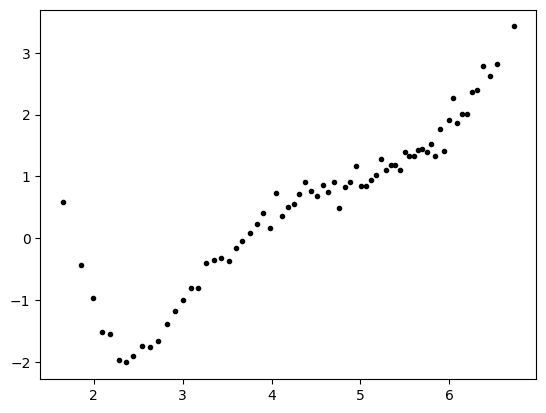

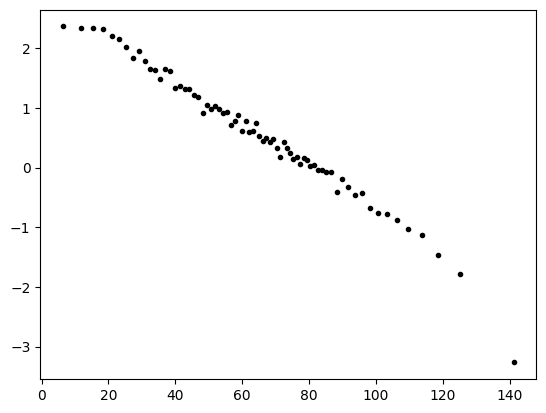

In [ ]:
eda_calibration(df.hangtime.values, df.is_out.values, 500)
plt.show()

eda_calibration(df.closest_fielder_coords_diff.values, df.is_out.values, 500)
plt.show()

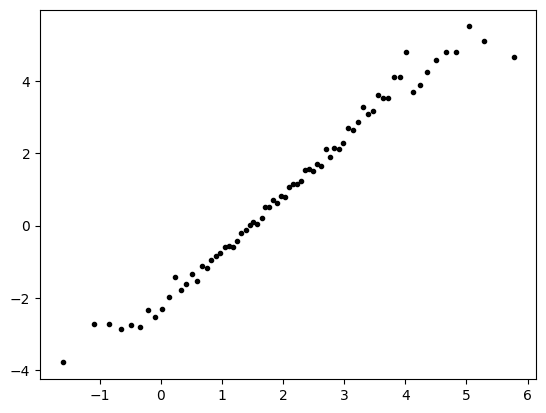

In [ ]:
df['time_diff'] = df.hangtime.values - df.closest_fielder_coords_diff.values / 27

eda_calibration(df.time_diff.values, df.is_out.values, 500)
plt.show()

Time diff is looking good

In [ ]:
#cross validation testing

def cross_val_func(features, iterations = 100, plot_iter = 25):

    train_acs = []
    train_f1=[]
    accs = []
    f1 = []
    for i in range(iterations):
        train, test = train_test_split(df, test_size = 0.3)
        mod = LogisticRegression().fit(train[features].values, train.is_out.values)
        preds = mod.predict(test[features].values)
        acc = np.mean(preds == test.is_out.values)
        accs.append(acc)
        f1.append(f1_score(test.is_out.values, preds))
        preds2 = mod.predict(train[features].values)
        acc2 = np.mean(preds2 == train.is_out.values)
        train_acs.append(acc2)
        train_f1.append(f1_score(train.is_out.values, preds2))

        if i%plot_iter == 0:
            probs = mod.predict_proba(test[features].values)[:,1]
            calibration(probs, test.is_out.values, 200)
            plt.show()

    plt.hist(train_acs, density = True)
    plt.title('Train Set Accuracy')
    plt.show()
    plt.hist(accs, density = True)
    plt.title('Test Set Accuracy')
    plt.show()
    plt.hist(train_f1, density = True)
    plt.title('Train Set F1')
    plt.show()
    plt.hist(f1, density = True)
    plt.title('Test Set F1')
    plt.show()

    print('train mean accuracy: ' + str(np.mean(train_acs)) + ', test mean accuracy: ' + str(np.mean(accs)) + ', train mean f1: ' + str(np.mean(train_f1)) +  ', test mean f1: ' + str(np.mean(f1)))

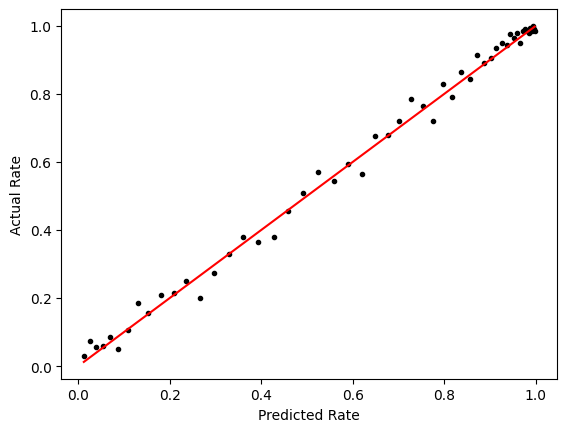

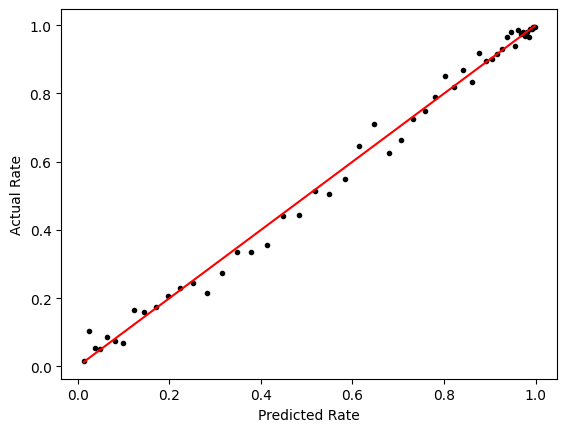

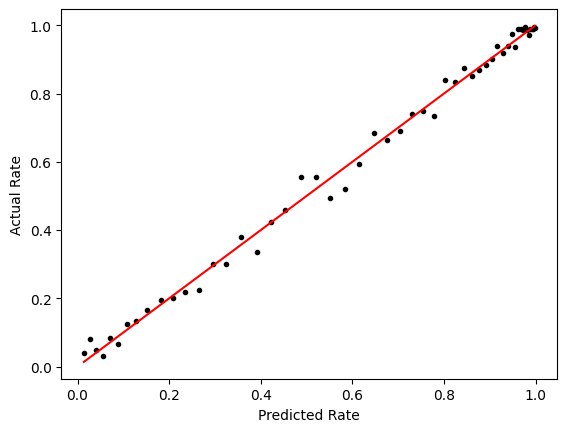

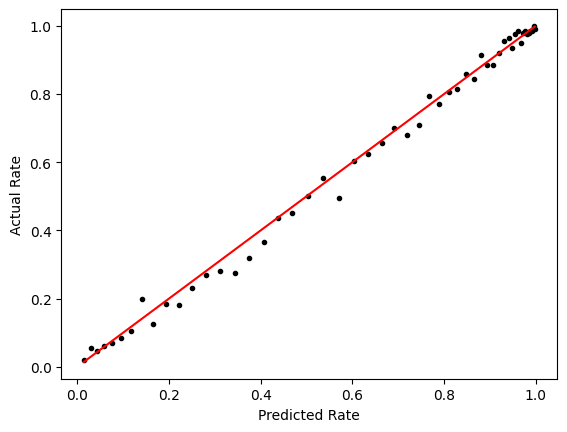

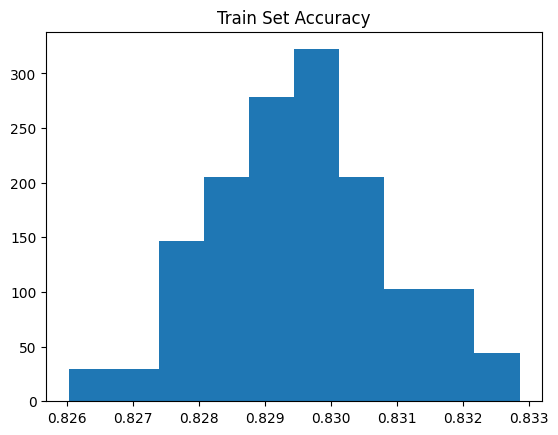

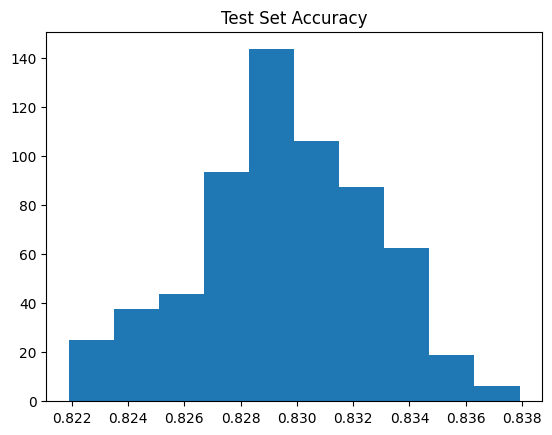

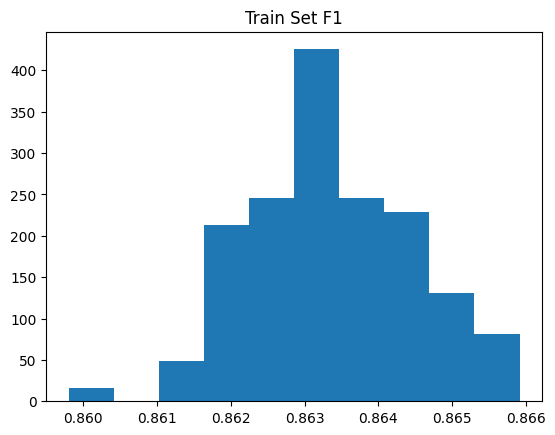

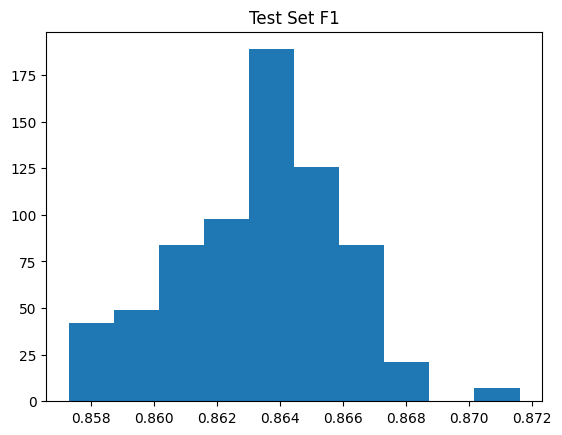

train mean accuracy: 0.8295713486736978, test mean accuracy: 0.8295591387827383, train mean f1: 0.8633704658741168, test mean f1: 0.8633002746077186


In [ ]:
#first set of features to test, the simplest, just time diff
cross_val_func(['time_diff'])

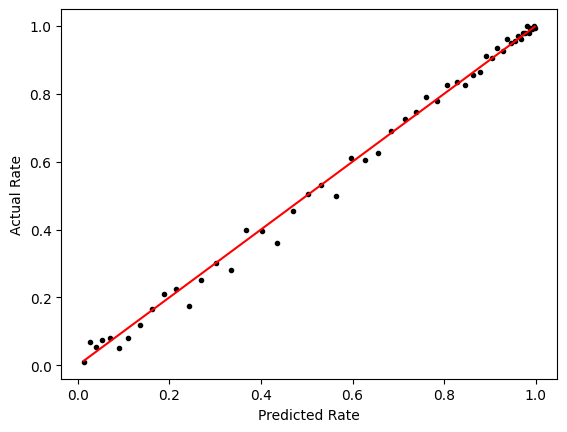

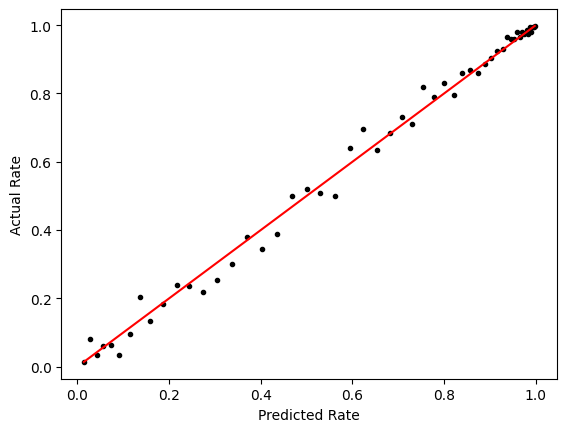

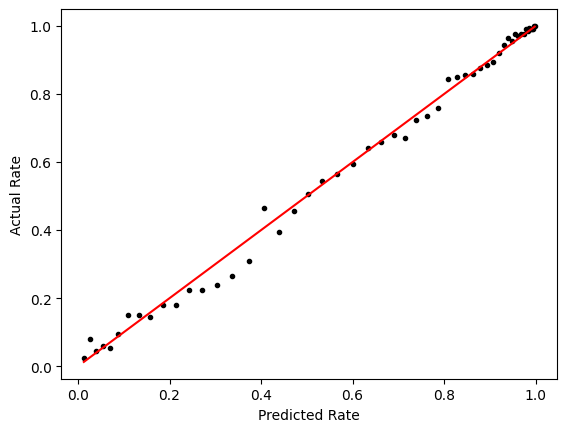

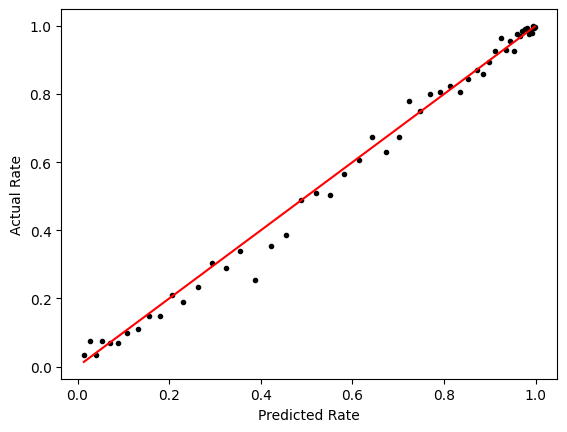

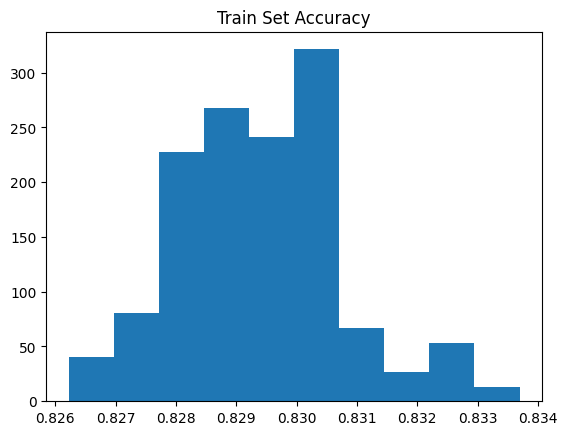

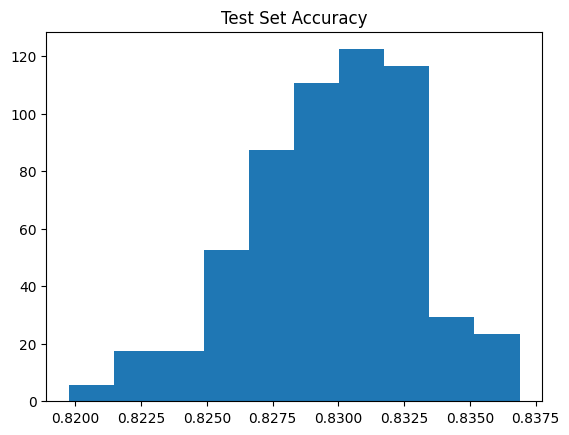

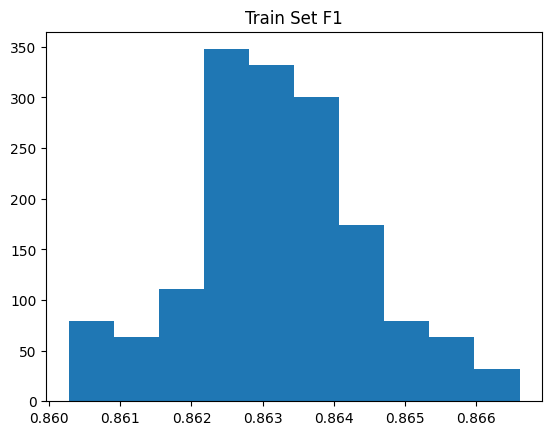

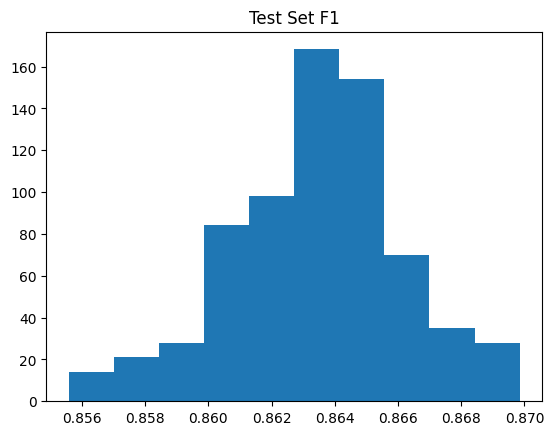

train mean accuracy: 0.8293959731543624, test mean accuracy: 0.8296998788330694, train mean f1: 0.8632303724533972, test mean f1: 0.8634779162921268


In [ ]:
cross_val_func(['time_diff', 'closest_fielder_backwards'])

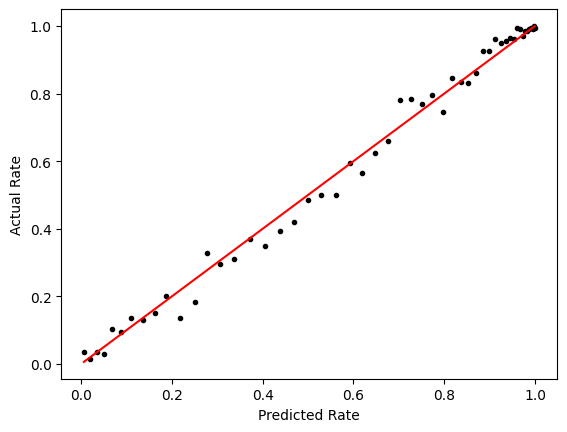

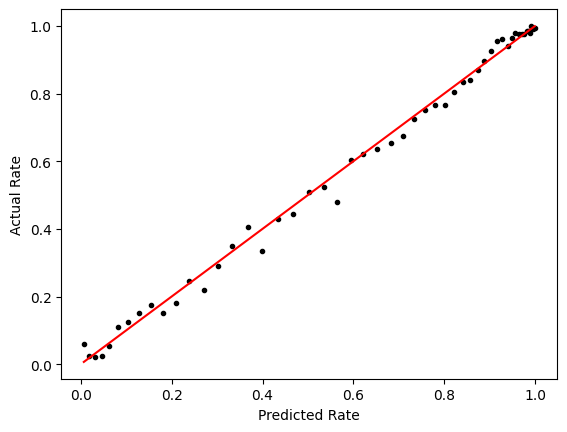

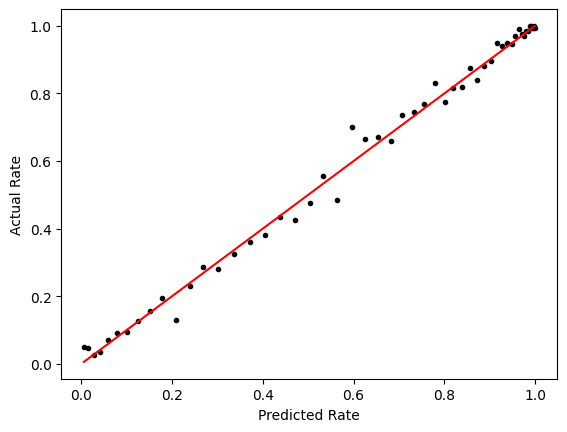

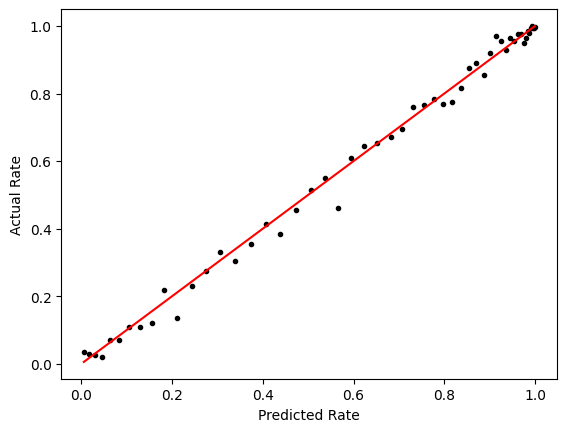

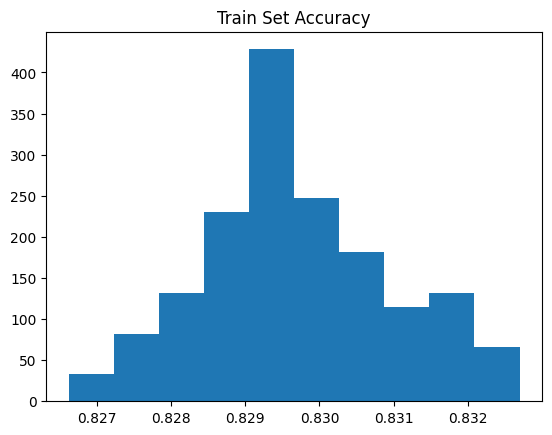

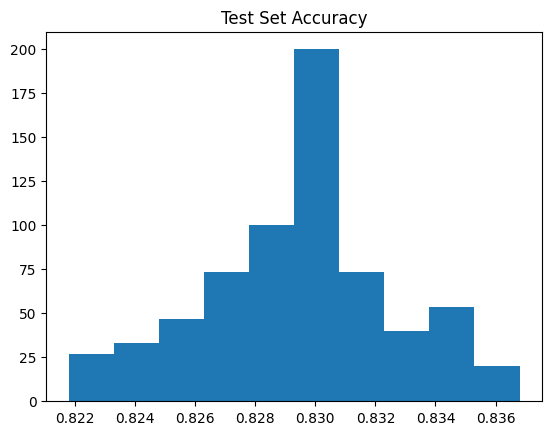

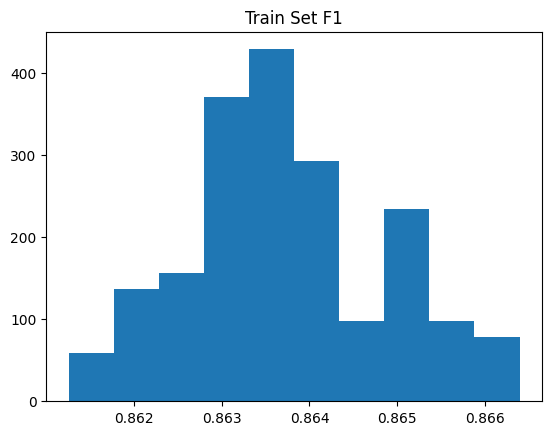

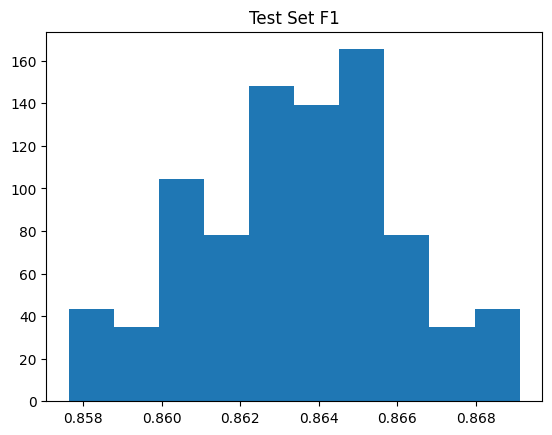

train mean accuracy: 0.8297051773729627, test mean accuracy: 0.8295125361170659, train mean f1: 0.8637485703483309, test mean f1: 0.8634963404596951


In [ ]:
df['back_time_inter'] = df.time_diff.values * df.closest_fielder_backwards.values
cross_val_func(['time_diff', 'closest_fielder_backwards', 'back_time_inter'])

The time diff backward interaction doesn't help a whole lot either.

In [ ]:
#coefficients
train, test = train_test_split(df, test_size = 0.3)

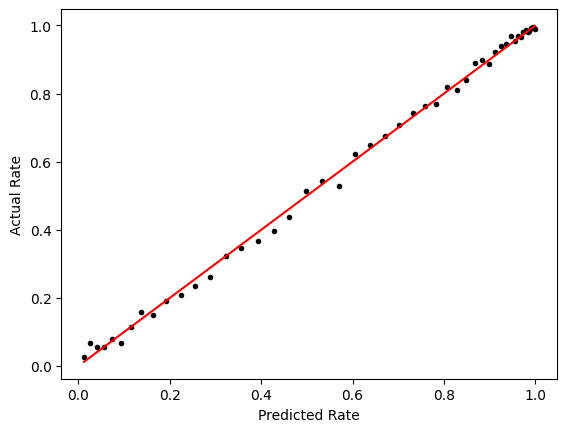

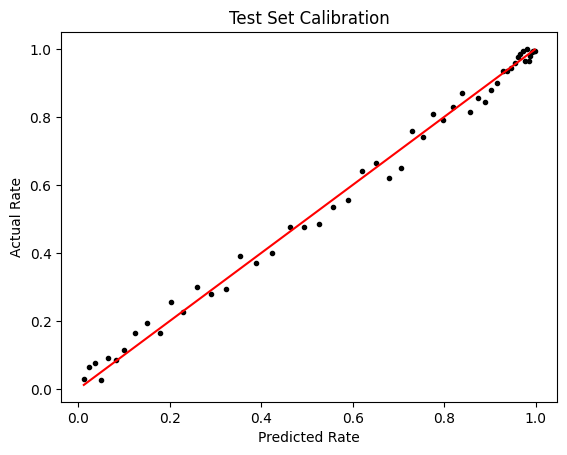

(array([[1.53176316]]), array([-2.21412142]))

In [ ]:
features1 = ['time_diff']
mod = LogisticRegression().fit(train[features1].values, train.is_out.values)
tpre = mod.predict_proba(train[features1].values)
tepre = mod.predict_proba(test[features1].values)
calibration(tpre[:,1], train.is_out.values, 500)
plt.show()
calibration(tepre[:,1], test.is_out.values, 200)
plt.title('Test Set Calibration')
plt.show()

mod.coef_, mod.intercept_

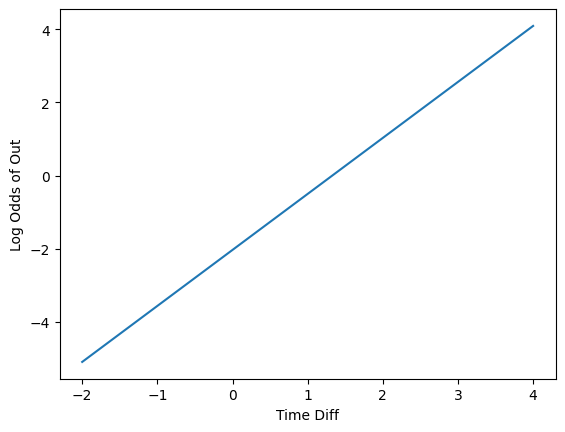

In [ ]:
#plot the first model
x= np.linspace(-2,4)
plt.plot(x, -2.03 + 1.53*x)
plt.xlabel('Time Diff')
plt.ylabel('Log Odds of Out')
plt.show()

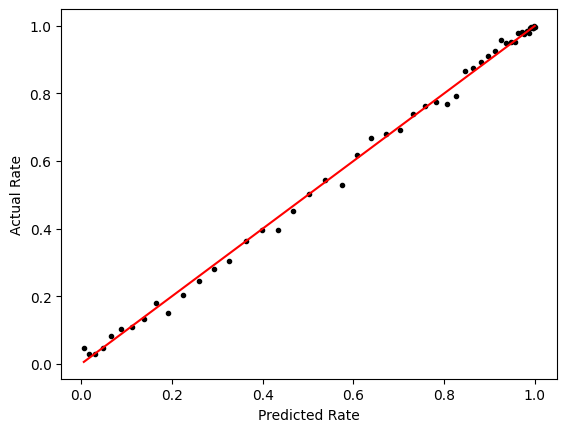

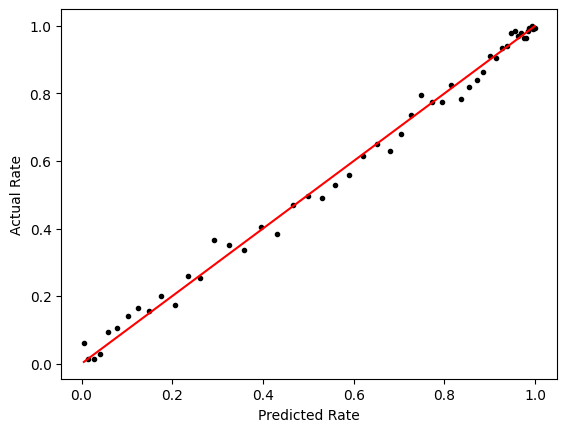

(array([[ 1.98839342,  1.0538434 , -0.64879158]]), array([-2.94447911]))

In [ ]:
features = ['time_diff', 'closest_fielder_backwards', 'back_time_inter']
mod = LogisticRegression().fit(train[features].values, train.is_out.values)
tpre = mod.predict_proba(train[features].values)
tepre = mod.predict_proba(test[features].values)
calibration(tpre[:,1], train.is_out.values, 500)
plt.show()
calibration(tepre[:,1], test.is_out.values, 200)
plt.show()
mod.coef_, mod.intercept_

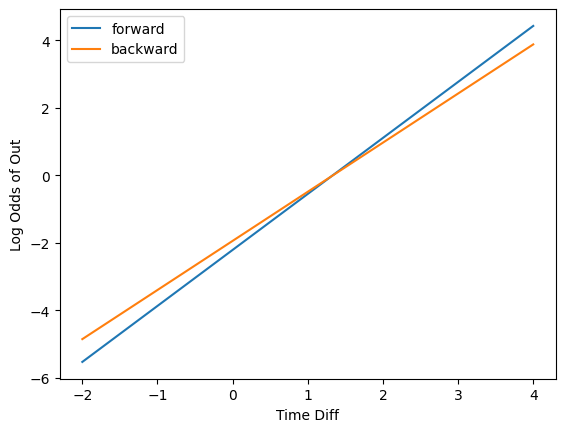

In [ ]:
#let's see the marginal effects for the second model
x = np.linspace(-2,4,100)
plt.plot(x, -2.21 + 1.66*x , label = 'forward')
plt.plot(x, -2.21 + 0.268 + (1.66 -0.204)*x, label = 'backward')
plt.legend()
plt.xlabel('Time Diff')
plt.ylabel('Log Odds of Out')
plt.show()

I don't see a huge benefit of including the backwards flag/interaction, and it looks like the difference between going forward vs backward is pretty small for most time diffs, so I'm just going to use the time diff model.

In [ ]:
#final model
features = ['time_diff']
mod = LogisticRegression().fit(df[features].values, df.is_out.values)

In [ ]:
mod.intercept_, mod.coef_

(array([-2.16869748]), array([[1.50402427]]))

In [ ]:
#manual predictions
fb_int = -2.16869748
fb_td_slope = 1.50402427

logodds = fb_int + fb_td_slope*df.time_diff.values
probits = torch.special.expit(torch.tensor(logodds, dtype = torch.float32)).numpy()

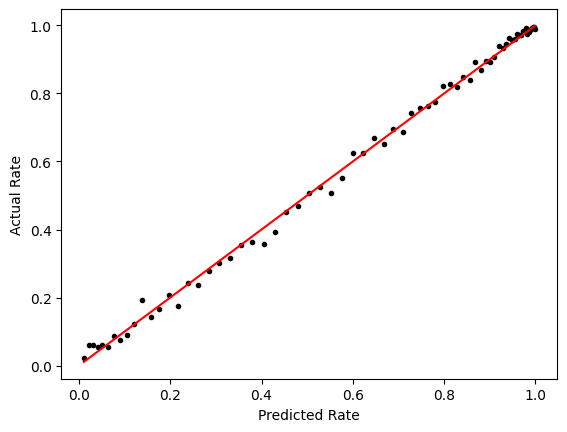

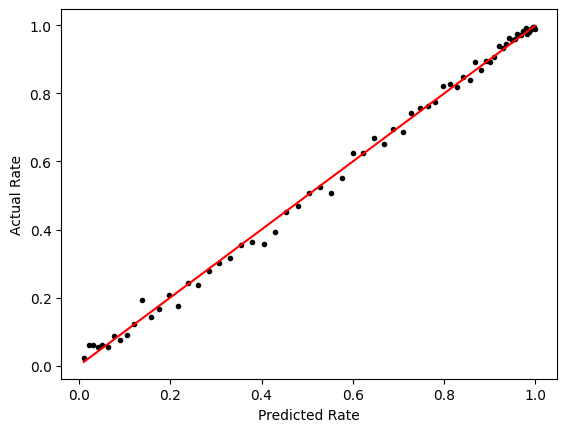

In [ ]:
calibration(probits, df.is_out.values, 500)
plt.show()
p = mod.predict_proba(df[features].values)[:,1]
calibration(p, df.is_out.values, 500)
plt.show()

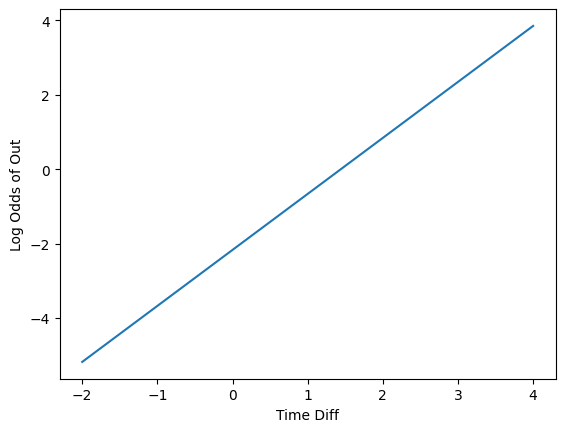

In [ ]:
#plot the first model
x= np.linspace(-2,4)
plt.plot(x, -2.16869748 + 1.50402427*x)
plt.xlabel('Time Diff')
plt.ylabel('Log Odds of Out')
plt.show()

This model incentivizes fielders to increase the time diff. Increasing the time diff will increase the probability of an out. Fielders obviously can't do anything about hang time, so the only way they can increase time diff is by moving closer to the landing spot of the ball, which is what we would want.